In [1]:
import numpy as np
import pandas as pd
import math
import os
import sys
import glob
import time
import pickle
import itertools
import altair as alt
alt.data_transformers.disable_max_rows()

from astropy import units as u
from astropy.timeseries import LombScargle

import fastdtw
from scipy.spatial.distance import euclidean

from sklearn.preprocessing import MinMaxScaler

from dtaidistance import dtw, clustering
from dtaidistance import dtw_visualisation as dtwvis

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

import multiprocessing as mp
from multiprocessing import Pool
print("Number of processors: ", mp.cpu_count())

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

Number of processors:  96


### Literature

With Semi-supervised learning:
- [DTW-D: Time Series Semi-Supervised Learning from a Single Example](http://chbrown.github.io/kdd-2013-usb/kdd/p383.pdf) 
- [Scaling up Dynamic Time Warping to Massive Datasets](http://www.cs.ucr.edu/~eamonn/pkdd99keogh_pazzani.pdf)

Implementations:
- [FastDTW: Toward Accurate Dynamic Time Warping in Linear Time and Space](https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf)
- https://github.com/talcs/simpledtw
- https://dtaidistance.readthedocs.io/en/latest/index.html

Astronomical applications:
- [Unsupervised Classification of Variable Stars](https://arxiv.org/pdf/1801.09723.pdf)
- [Central Engine Memory of Gamma-Ray Bursts and Soft Gamma-Ray Repeaters](https://arxiv.org/abs/1603.01381)
- [Reconstructing Gravitational Wave Core-Collapse Supernova Signals with Dynamic Time Warping](https://arxiv.org/abs/1901.02535)

Overview of time series classification methods feature and distance based:
- [Time-Series Classification Methods: Review and Applications to Power Systems Data](https://www.researchgate.net/publication/322184827_Time-Series_Classification_Methods_Review_and_Applications_to_Power_Systems_Data)

Review papers on time series classification methods:
- [Deep learning for time series classification: a review](https://arxiv.org/pdf/1809.04356.pdf)
- [](https://arxiv.org/abs/1602.01711)

### First Test:

1. pick out 5 source types: EA, EB, EW, ROT, RRAB (x2 of each)
2. phase fold light curve using ASASSN period (manually picked out good periods)
3. bin into uniform time grid
4. compute distances for all (10 choose 2)=45 combinations using metrics:
 - euclidean distance
 - dynamic time warping
 - DTW-D = DTW / ED

Future things:
- in principle, implementation of DTW-D should perform better with less complex light curves

![](nb_figures/fig1.png)
![](nb_figures/fig2.png)

- amplitude scaling (affine transformation versions of DTW)?

### Read in ASASSN reference list

In [2]:
tess_xm = pd.read_csv(tb.cat_dir + '/asassn_tess_xm.csv.gz')
psamp = tess_xm[~np.isnan(tess_xm['period'])]
ref = psamp[psamp['period'] < 28]

pos_ref = ref[ref['Type'].isin(['EA', 'EB', 'EW'])]
neg_ref = ref[~ref['Type'].isin(['EA', 'EB', 'EW'])]
print(len(pos_ref), len(neg_ref))

656 750


In [ ]:
pos_ref['Type'].value_counts().plot(kind='bar', figsize=[18,6])

In [ ]:
neg_ref['Type'].value_counts().plot(kind='bar', figsize=[18,6])

In [ ]:
# Hold out reference data
pos_train = pos_ref[0:300]
neg_train = neg_ref[0:300]

pos_test = pos_ref[300:]
neg_test = neg_ref[300:]

In [ ]:
np.where(np.array(ref['Type']) == 'RRAB')

### Phase Fold and bin data

5 EA


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


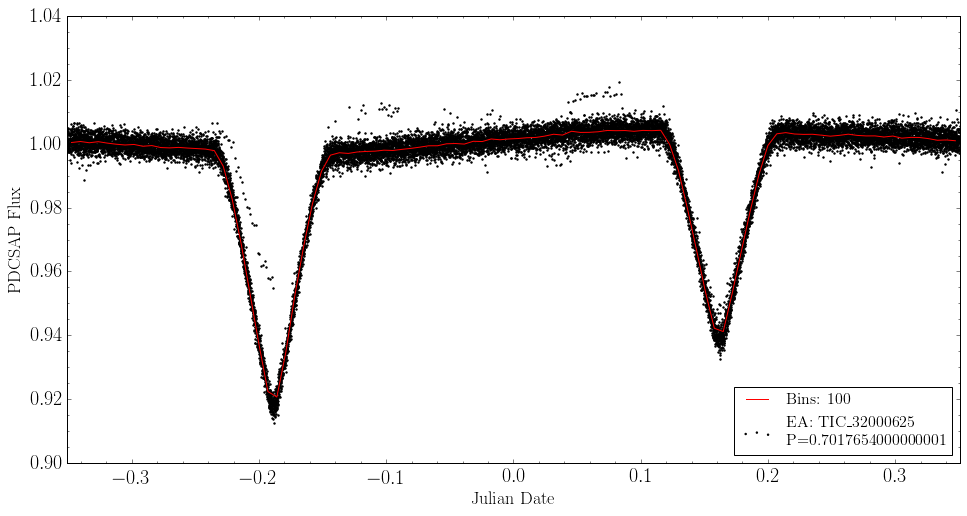

16 EA


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


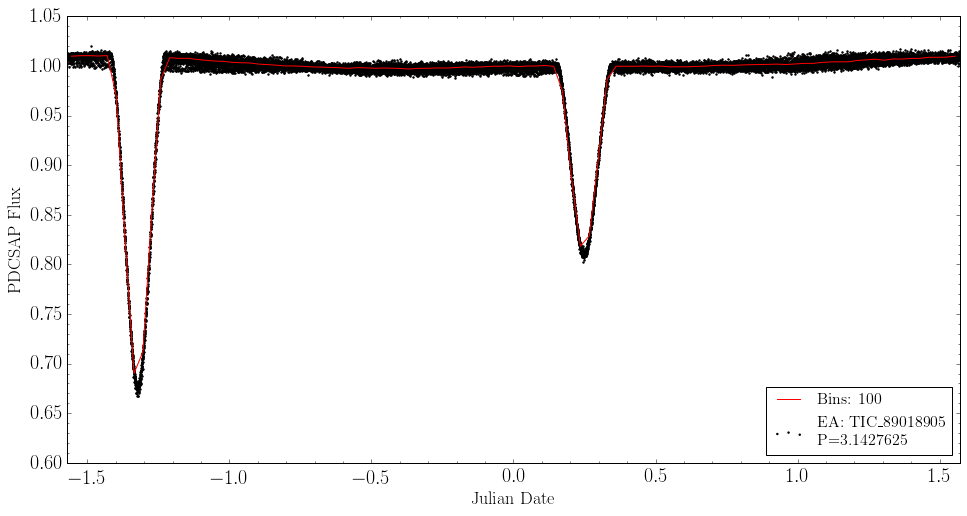

20 EB
Stacking 1 light curve(s).


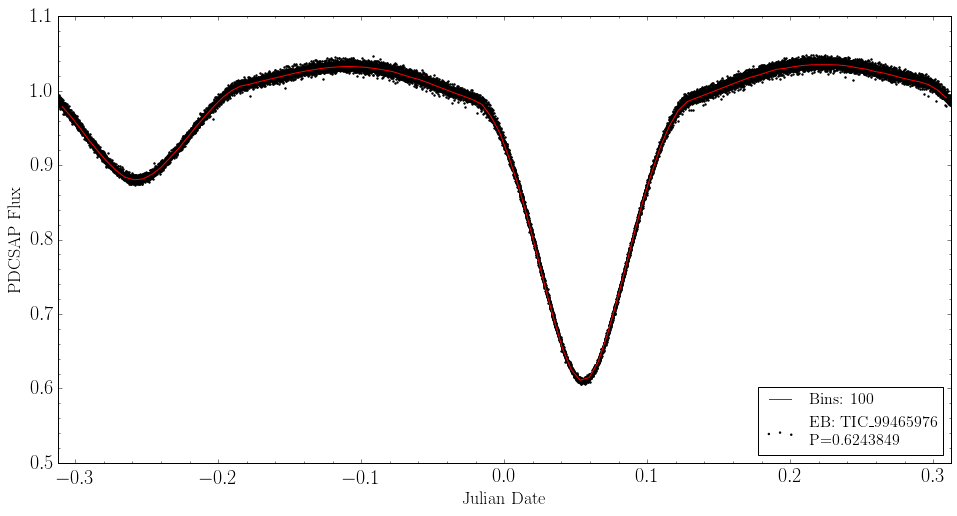

25 EB
Stacking 1 light curve(s).


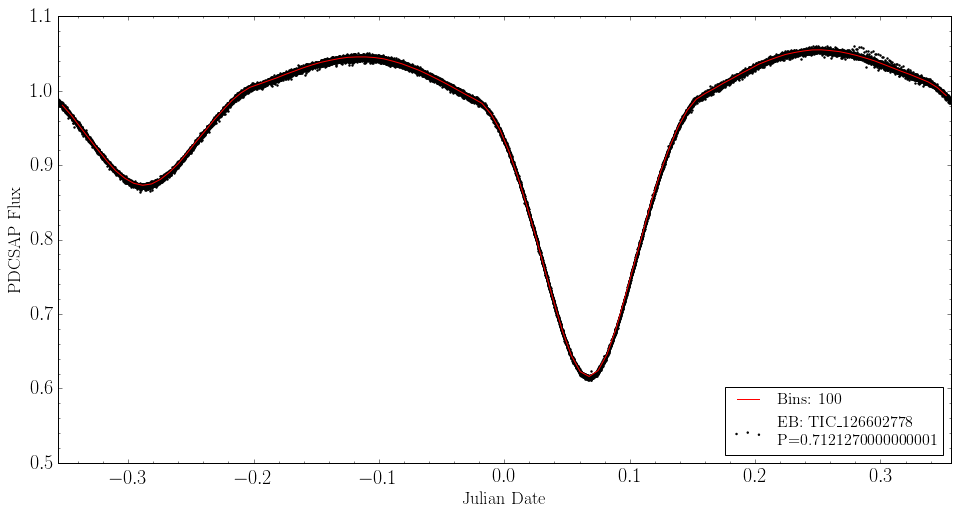

4 EW
Stacking 1 light curve(s).


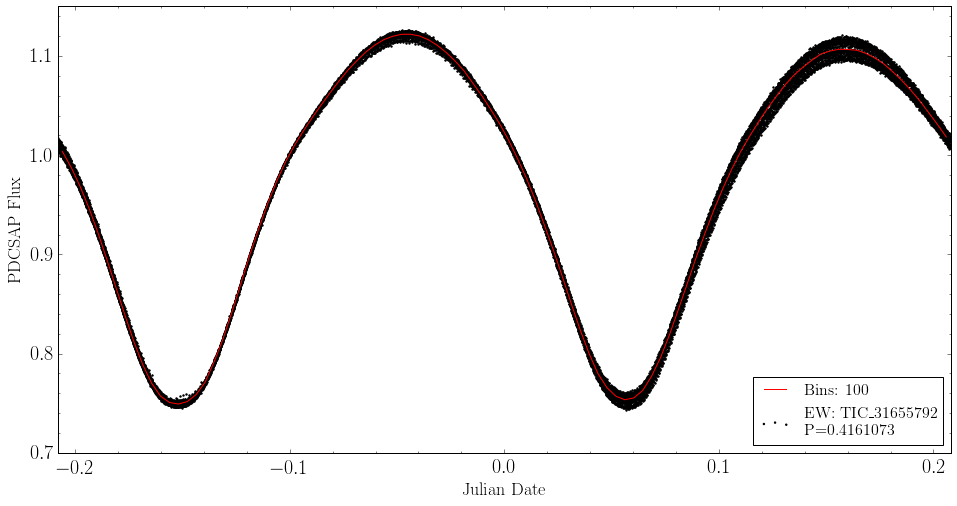

6 EW
Stacking 1 light curve(s).


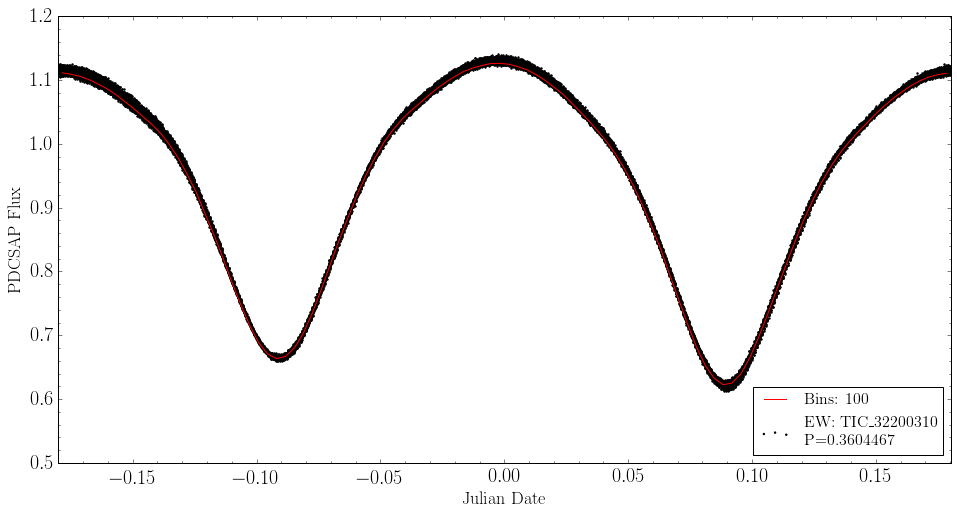

14 ROT
Stacking 1 light curve(s).


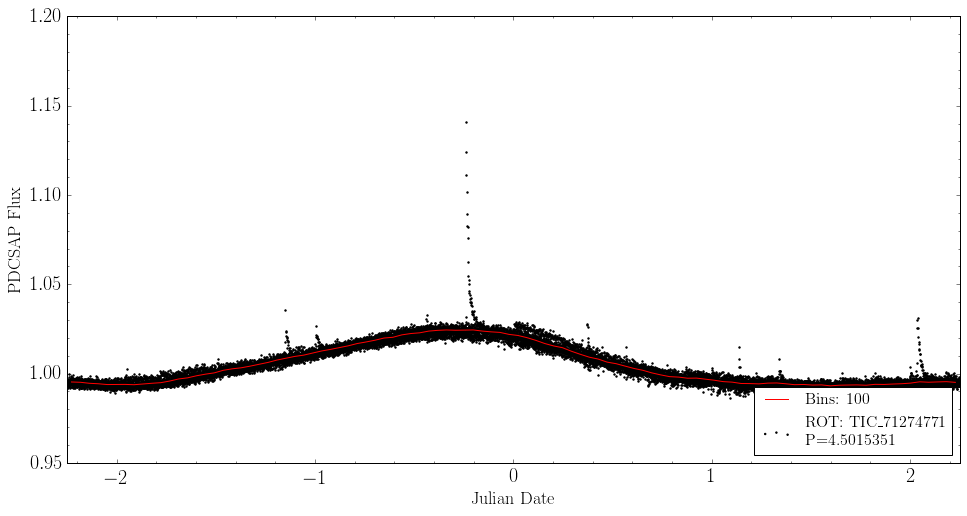

21 ROT
Stacking 1 light curve(s).


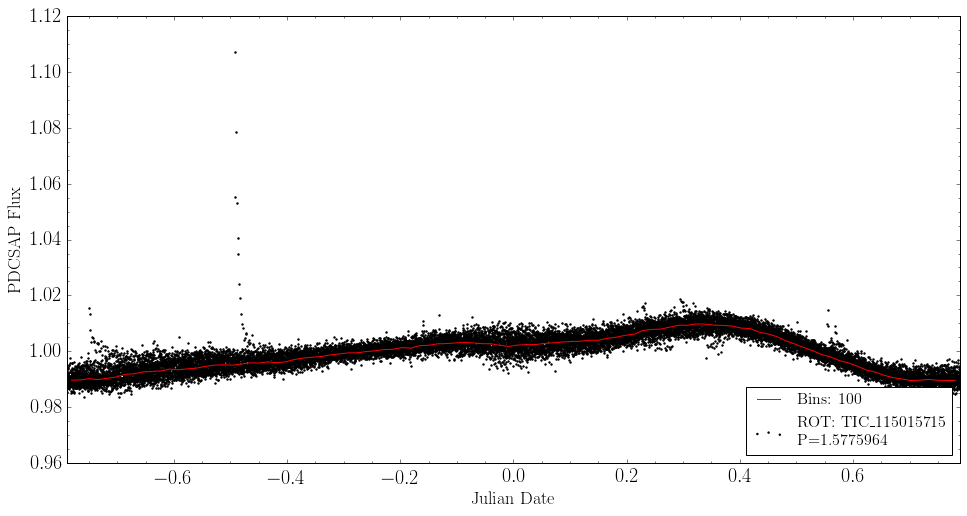

62 RRAB
Stacking 1 light curve(s).


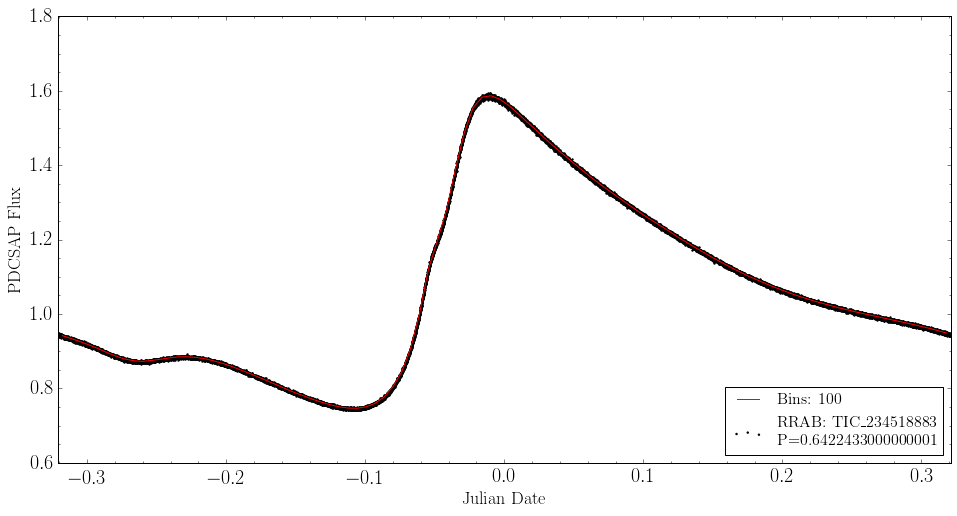

117 RRAB
Stacking 1 light curve(s).


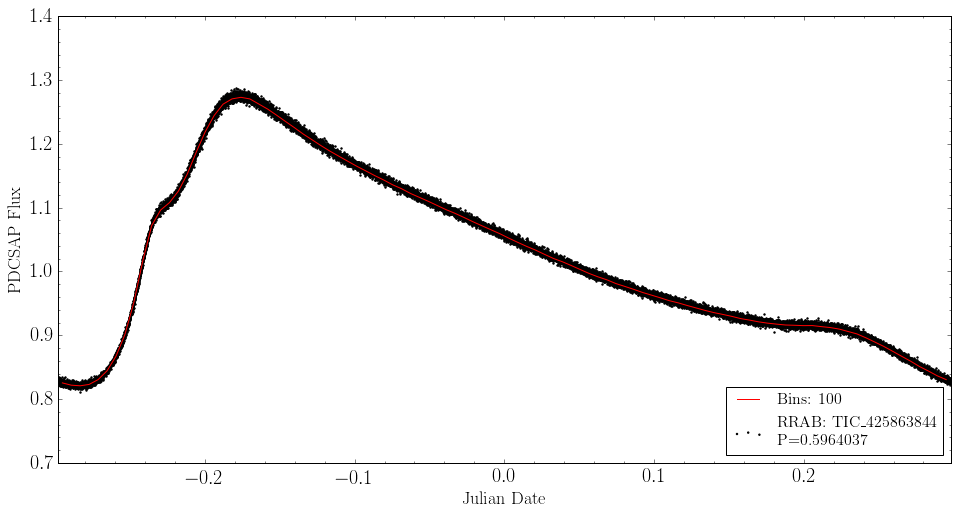

In [3]:
tsteps = 100
tarr = np.arange(0,tsteps,1)
pharr = np.linspace(0,1,tsteps)

farr = []
ids = []
periods = []
types = []

demo = [5,16, 20,25, 4,6, 14,21, 62,117]
# demo = np.arange(0,len(ref))

for i in demo:
    tic_id = list(ref['tic_id'])[i]
    sec = list(ref['sector'])[i]
    typ = list(ref['Type'])[i]
    per = list(ref['period'])[i]
    print(i, typ)
    
    data_full = tb.readSourceFiles(tic_id, sector=sec)[0]  
    data      = data_full.fold(period=per*u.day) 
    bin_flux  = tb.binData(data, tsteps)
    
    tbins = np.linspace(min(data.time.jd), max(data.time.jd), tsteps+1)
    bin_width = (tbins[1] - tbins[0])/2

    plt.figure(figsize=[16,8])
    plt.ticklabel_format(useOffset=False)
    plt.scatter(data.time.jd, data['pdcsap_flux']/np.nanmedian(data['pdcsap_flux']), \
             color='k', s=2, label=f"{typ}: TIC\_{tic_id}\nP={per}")
    plt.plot(tbins[:tsteps]+bin_width, bin_flux, color='r', label=f'Bins: {tsteps}')

    plt.ylabel('PDCSAP Flux', fontsize=18)
    plt.xlabel('Julian Date', fontsize=18)
    plt.xlim(min(data.time.jd), max(data.time.jd))
    plt.legend(loc='lower right', fontsize=16)
    plt.minorticks_on()
    plt.savefig(f'{tb.plot_dir}/dtw_ex_classes/TIC_{tic_id}.png')
    plt.show() 
    
    farr.append(bin_flux)
    ids.append(tic_id)
    periods.append(per)
    types.append(typ)

In [ ]:
# combos = list(itertools.combinations(np.arange(0,10), 2))
# combos = [(0,1), (0,3), (0,5), (0,7), (0,9)]
combos = [(2,1), (2,3), (2,5), (2,7), (2,9)]

### Euclidean Distance

In [ ]:
edist = []
for pair in combos:
    flux1 = np.array(farr[pair[0]])
    flux2 = np.array(farr[pair[1]])
    
    #Shift minimum flux to t=0
    flux1 = np.roll(np.array(flux1), tsteps-np.argmin(flux1))
    flux2 = np.roll(np.array(flux2), tsteps-np.argmin(flux2)-1)
    
    #Scale amplitude between 0 and 1
    data1 = np.vstack([tarr, flux1]).T
    scaler = MinMaxScaler()
    scaler.fit(data1)
    flux1 = scaler.transform(data1).T[1]
    
    data2 = np.vstack([tarr, flux2]).T
    scaler = MinMaxScaler()
    scaler.fit(data2)
    flux2 = scaler.transform(data2).T[1]
    
    d = np.sum(np.abs(flux2 - flux1))
    edist.append(d)
    
    plt.figure(figsize=[16,8])
    plt.plot(pharr, flux1, label=f'Type: {types[pair[0]]}')
    plt.plot(pharr, flux2, label=f'Type: {types[pair[1]]}')
    for t in range(tsteps):
        plt.plot((pharr[t], pharr[t]), (flux1[t], flux2[t]), color='k')
    plt.title(f'Euclidean Distance: {str(np.round(d,3))}', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.ticklabel_format(useOffset=False)
    plt.show()

### Dynamic Time Warping 

In [4]:
dtw_dist = []
for pair in combos:
    flux1 = np.array(farr[pair[0]])
    flux2 = np.array(farr[pair[1]])
    
    #Shift minimum flux to t=0
    flux1 = np.roll(np.array(flux1), tsteps-np.argmin(flux1))
    flux2 = np.roll(np.array(flux2), tsteps-np.argmin(flux2)-1)
    
    #Scale amplitude between 0 and 1
    data1 = np.vstack([tarr, flux1]).T
    scaler = MinMaxScaler()
    scaler.fit(data1)
    flux1 = scaler.transform(data1).T[1]
    
    data2 = np.vstack([tarr, flux2]).T
    scaler = MinMaxScaler()
    scaler.fit(data2)
    flux2 = scaler.transform(data2).T[1]

    d, paths = dtw.warping_paths(flux1, flux2, window=5, psi=2)
    matches = dtw.best_path(paths)
    
    dtw_dist.append(d)
    
    plt.figure(figsize=[16,8])
    plt.plot(pharr, flux1, label=f'Type: {types[pair[0]]}')
    plt.plot(pharr, flux2, label=f'Type: {types[pair[1]]}')
    
    for m in matches:
        plt.plot((pharr[m[0]], pharr[m[1]]), (flux1[m[0]], flux2[m[1]]), color='k')
    plt.title(f'DTW Distance: {str(np.round(d,3))}', fontsize=18)
    plt.legend(loc='lower right', fontsize=16)
    plt.ticklabel_format(useOffset=False)
    plt.show()

NameError: name 'combos' is not defined

In [ ]:
edist    = np.array(edist)
dtw_dist = np.array(dtw_dist)

np.vstack([edist, dtw_dist, dtw_dist/edist]).T

In [ ]:
dtw_dist